In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from scipy.stats import randint, uniform

# Loading the data

In [3]:
train=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
test=pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

In [4]:
display('Train:',train.head())
display('Test:',test.head())

'Train:'

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


'Test:'

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...


# Summary of the data

In [5]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    summ['top value'] = desc['top'].values
    summ['Freq'] = desc['freq'].values

    return summ

In [6]:
summary(train.drop(columns=["ID"])).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
RecipeNumber,int64,0,0,100,1.000000,100.000000,38.624377,29.672351,nan,nan
RecipeCode,int64,0,0,100,386.000000,191775.000000,21785.990833,23883.189918,nan,nan
RecipeName,object,0,0,100,nan,nan,nan,nan,Cheeseburger Soup,553
CommentID,object,0,0,13636,nan,nan,nan,nan,sp_aUSaElGf_12259_c_149978,1
UserID,object,0,0,10783,nan,nan,nan,nan,u_1oKVZoIOMWJ2j7TA7py2BIbf1mm,20
UserName,object,0,0,10620,nan,nan,nan,nan,mjlouk,21
UserReputation,int64,0,0,20,0.000000,510.000000,2.160311,10.086424,nan,nan
CreationTimestamp,int64,0,0,2422,1613035336.000000,1665756035.000000,1623713409.344603,5444020.160422,nan,nan
ReplyCount,int64,0,0,4,0.000000,3.000000,0.014520,0.137323,nan,nan
ThumbsUpCount,int64,0,0,57,0.000000,80.000000,1.098269,4.166487,nan,nan


* Shows 2 missing values in Recipe_Review column
* Total 100 Recipes are present

<Axes: xlabel='Rating', ylabel='count'>

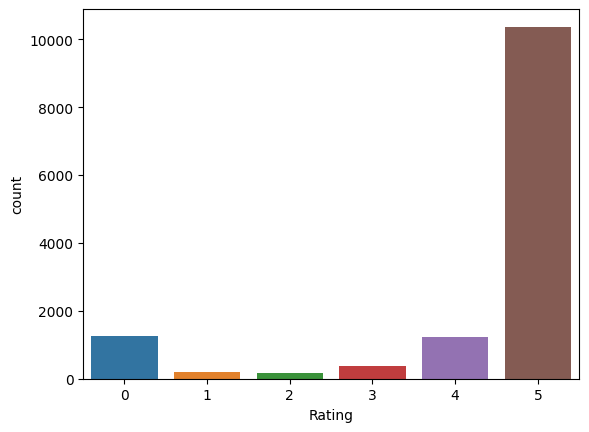

In [7]:
sns.countplot(x='Rating', data=train)

We can observe that the dataset provided has imbalanced classes which can get biased towards the majority class.

Tried using SMOTE for minority class but it provided a great training accuracy but increased the shape of training set extremely and behaved poorly for unseen data.
Even class weights equal to inverse of class frequencies and class weight= 'balanced' where not performing well.

Implemented stratify=y for splitting the data.

In [8]:
class_distribution = train['Rating'].value_counts(normalize=False)
print("Class Distribution:")
print(class_distribution)

Class Distribution:
Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64


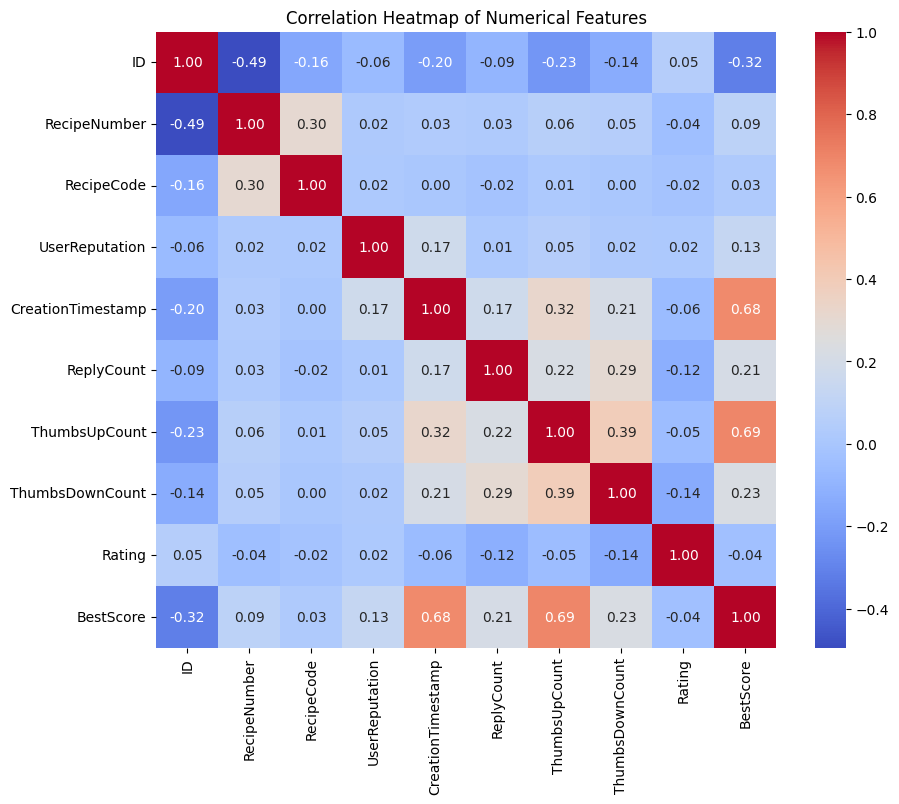

In [9]:
numerical = train.select_dtypes(include=['int', 'float'])

correlation_matrix = numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


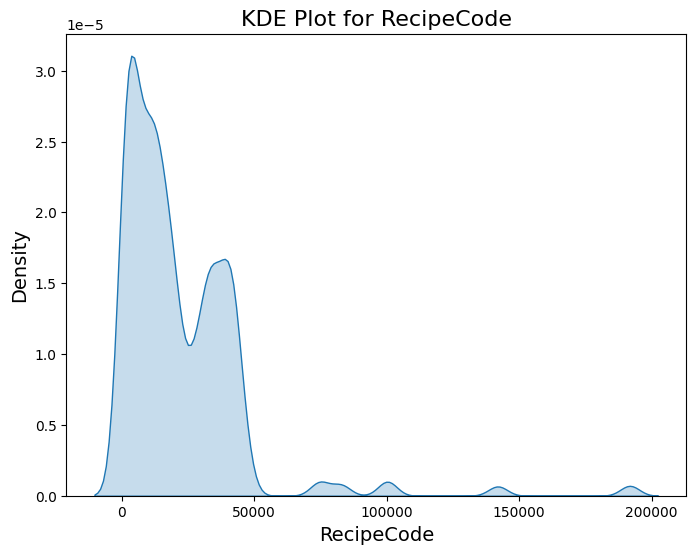

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


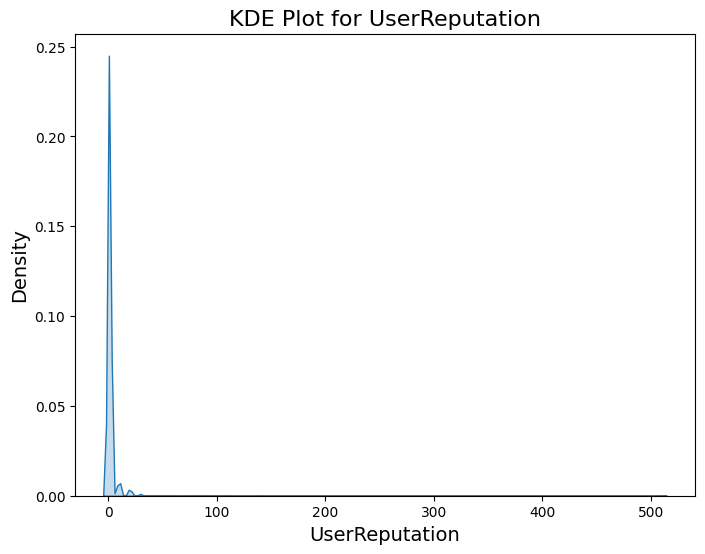

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


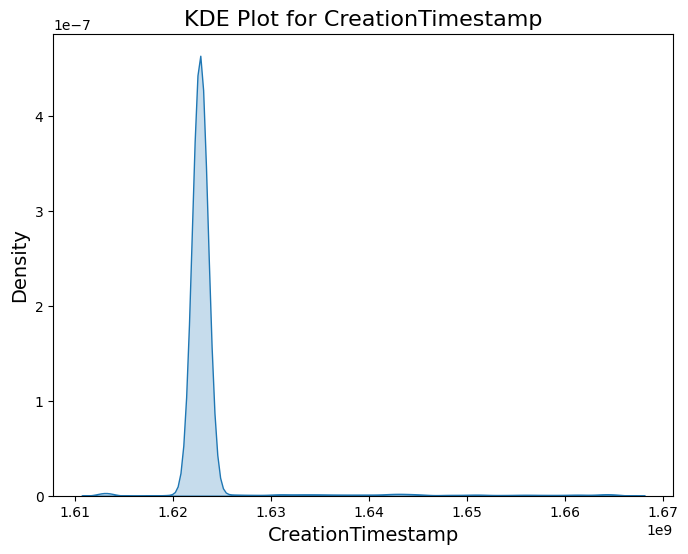

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


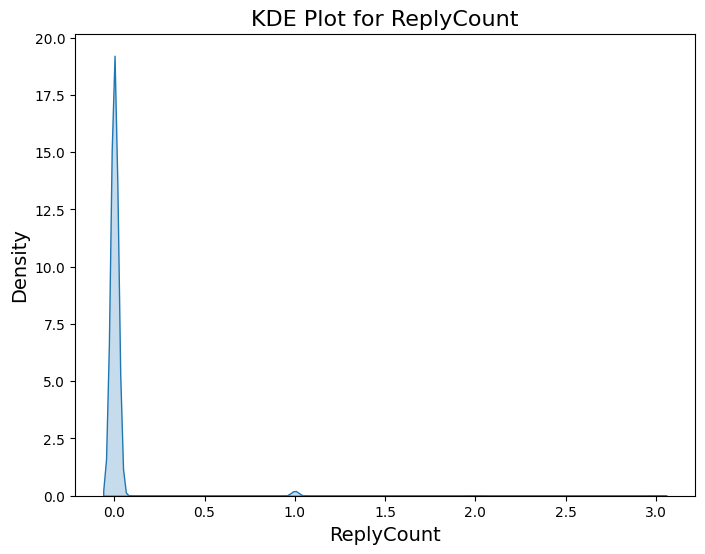

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


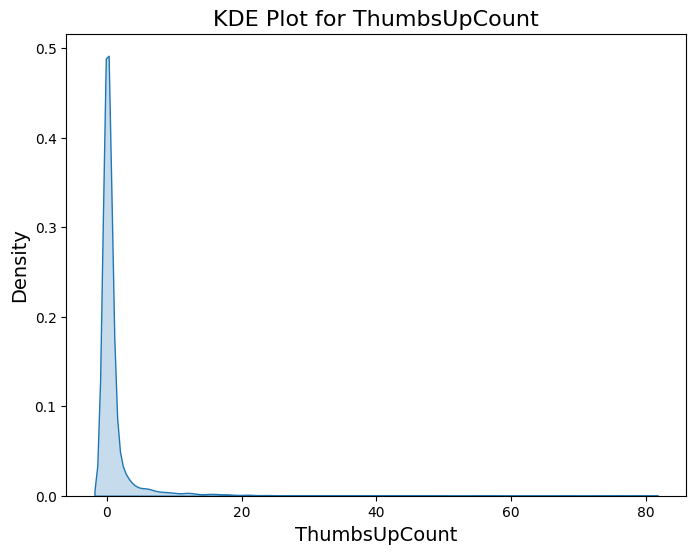

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


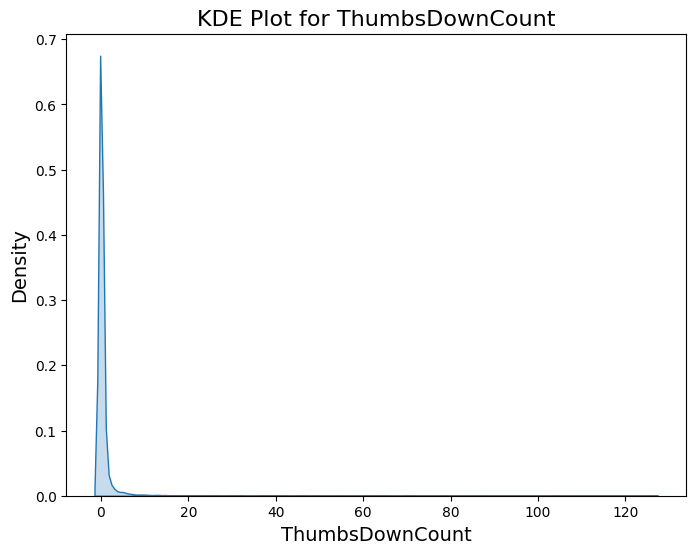

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


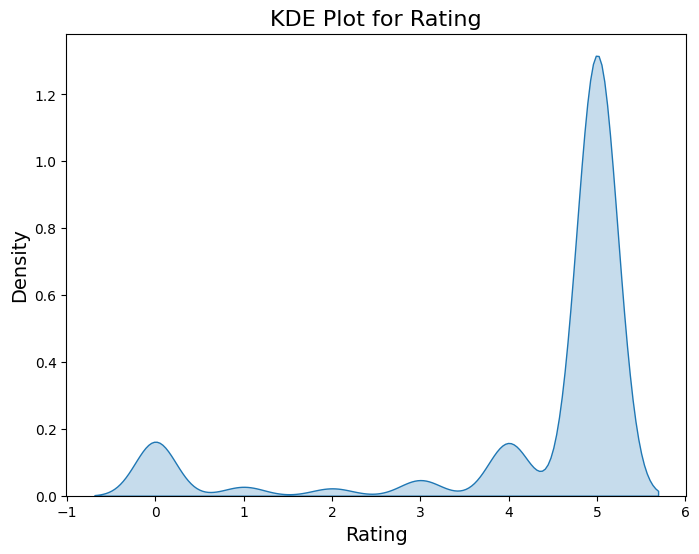

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


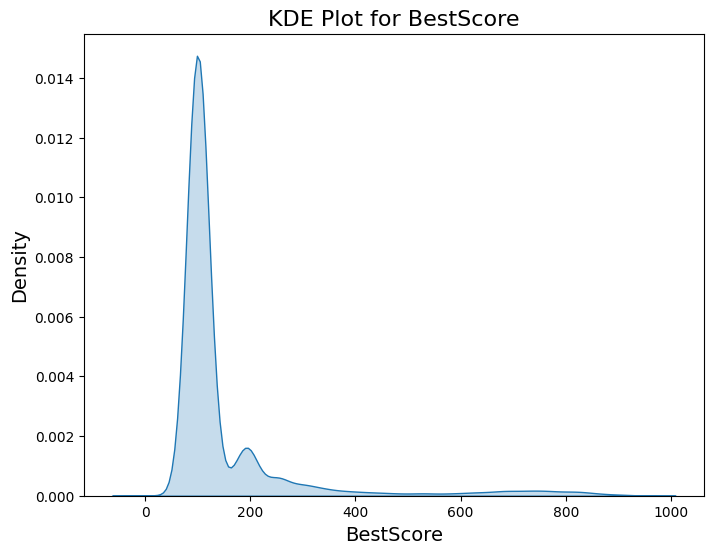

In [10]:
numeric_columns = train.select_dtypes(include=['float64', 'int64']).drop(columns=['ID','RecipeNumber'], axis=1)

for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(train[col], fill=True)
    plt.title(f'KDE Plot for {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.show()

In [11]:
train['RecipeName'].unique()

array(['Banana Bars with Cream Cheese Frosting', 'Simple Taco Soup',
       'Cheeseburger Soup', 'Grilled Huli Huli Chicken',
       'Cauliflower Soup', 'Favorite Chicken Potpie',
       'Fluffy Key Lime Pie', 'Seafood Lasagna', 'Cheesy Ham Chowder',
       'First-Place Coconut Macaroons', 'Rhubarb Custard Bars',
       'Garlic Beef Enchiladas', 'Pork Chops with Scalloped Potatoes',
       'Peanut Butter Cup Cheesecake', 'Li’l Cheddar Meat Loaves',
       'Chicken Wild Rice Soup', 'Flavorful Chicken Fajitas',
       'Enchilada Casser-Ole!', 'Creamy White Chili',
       'Stuffed Pepper Soup', 'Lemon Blueberry Bread',
       'Chicken and Dumplings', 'Porcupine Meatballs',
       'Simple Au Gratin Potatoes', 'Basic Homemade Bread',
       'Zucchini Cupcake', 'Forgotten Jambalaya', 'Ravioli Lasagna',
       'Contest-Winning New England Clam Chowder', 'Basic Banana Muffins',
       'Creamy Grape Salad', 'Big Soft Ginger Cookies',
       'Pumpkin Spice Cupcakes with Cream Cheese Frosting',
 

# Preprocessing steps
Handling special characters in RecipeName column of the train and test data.

In [12]:
specialchar = ["’", "-","‘"]

for c in specialchar:
    train['RecipeName'] = train['RecipeName'].str.replace(c, "")
    test['RecipeName'] = test['RecipeName'].str.replace(c, "")

In [13]:
train['Recipe_Review'] = train['Recipe_Review'].fillna('')

In [14]:
train.shape

(13636, 15)

In [15]:
test.shape

(4546, 14)

In [16]:
X = train.drop(['Rating'], axis=1)  
y = train['Rating']  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42,
                                                 stratify=y)
Numerical = X_train.select_dtypes(['int', 'float']).columns
Categorical=['RecipeName', 'CommentID', 'UserID', 'UserName']

In [17]:
numerical_pipeline = Pipeline([('scaler', StandardScaler())])

categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [18]:
preprocessing = ColumnTransformer(transformers=[('num', numerical_pipeline, Numerical),
        ('cat', categorical_pipeline, Categorical)], 
                                  remainder='passthrough')

**Text Feature Extraction using TfdifVectorizer**

TfidfVectorizer(max_features=1000) followed by TruncatedSVD(n_components=100) performs feature extraction (through dimensionality reduction) after feature creation.

In [19]:
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)), 
    ('svd', TruncatedSVD(n_components=100)) 
])

In [20]:
X_text = tfidf_pipeline.fit_transform(X_train['Recipe_Review'])
X_val_text=tfidf_pipeline.transform(X_val['Recipe_Review'])
test_text=tfidf_pipeline.transform(test['Recipe_Review'])

In [21]:
X_combined = sp.hstack((preprocessing.fit_transform(X_train.drop(['Recipe_Review'], axis=1)), X_text))
X_val_combined = sp.hstack((preprocessing.transform(X_val.drop(['Recipe_Review'], axis=1)), X_val_text))
test_combined = sp.hstack((preprocessing.transform(test.drop(['Recipe_Review'], axis=1)), test_text))

In [22]:
print(X_combined.shape)
print(X_val_combined.shape)

(9545, 25422)
(4091, 25422)


RandomForestClassifier is used to fit the training set and get importances of features. A threshold is set for selecting the features by going through thr feature_importances and hence indices are founf for them and new training set is created.
Similarly with validation and test dataset.


In [23]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_combined, y_train)

feature_importances = rf.feature_importances_


In [24]:
threshold = 0.0001

selected_features = [(i, importance) for i, importance in enumerate(feature_importances) if importance >= threshold]

selected_indices, selected_importances = zip(*selected_features)

In [25]:
len(selected_indices)

288

In [26]:
X_combined_csc = X_combined.tocsc()
X_val_combined_csc=X_val_combined.tocsc()
test_combined_csc=test_combined.tocsc()

X_train_new = X_combined_csc[:, list(selected_indices)]
X_val_new = X_val_combined_csc[:, list(selected_indices)]
test_new = test_combined_csc[:, list(selected_indices)]

In [27]:
print(X_train_new.shape)

(9545, 288)


**cv value for performing cross-validation on the data.**

 Stratified K-Fold ensures that each fold maintains the same class distribution as the original dataset.


In [28]:
cv= StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# 1. Logistic Regression
Logistic regression can be extended naturally to handle multiclass classification problems through techniques like multinomial logistic regression.

In [29]:
log_reg= LogisticRegression(random_state=42, multi_class='multinomial',
                            max_iter=1000)
log_reg.fit(X_train_new, y_train)
y_pred=log_reg.predict(X_val_new)
cr=cross_val_score(log_reg,X_train_new, y_train,cv=cv)
print("Mean Training Accuracy of LogisticRegression: {:.4f} %".format(cr.mean()*100))

Mean Training Accuracy of LogisticRegression: 77.2132 %


Validation score: 0.7709606453189929
              precision    recall  f1-score   support

           0       0.53      0.14      0.23       382
           1       0.36      0.13      0.19        63
           2       0.40      0.04      0.07        52
           3       0.14      0.03      0.05       110
           4       0.34      0.08      0.12       372
           5       0.79      0.98      0.88      3112

    accuracy                           0.77      4091
   macro avg       0.43      0.23      0.26      4091
weighted avg       0.70      0.77      0.71      4091



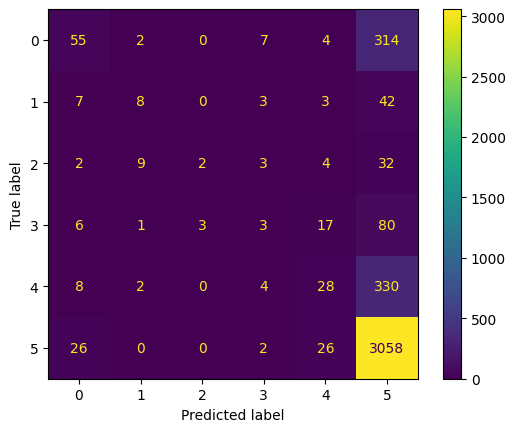

In [30]:
print('Validation score:', log_reg.score(X_val_new, y_val))
print(classification_report(y_val,y_pred))
print(ConfusionMatrixDisplay.from_predictions(y_val, y_pred))

 **Hyperparameter tuning performed by RandomizedSearchCV**

In [31]:
param_dist = {
    'C': [0.01, 0.1, 1, 10,50],
    'warm_start':[True,False]
}

log_reg=LogisticRegression(random_state=42, multi_class='multinomial',max_iter=1000)
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_new, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_model_log = random_search.best_estimator_
y_pred_log =best_model_log.predict(X_val_new)

accuracy_log = accuracy_score(y_val, y_pred_log)
recall_log=recall_score(y_val,y_pred_log, average='weighted')
f1_score_log=f1_score(y_val,y_pred_log, average='weighted')
precision_log=precision_score(y_val,y_pred_log, average='weighted')

print('Validation Accuracy:', accuracy_log * 100)

Best Parameters: {'warm_start': False, 'C': 1}
Best Score: 0.7723415400733368
Validation Accuracy: 77.09606453189929


              precision    recall  f1-score   support

           0       0.53      0.14      0.23       382
           1       0.36      0.13      0.19        63
           2       0.40      0.04      0.07        52
           3       0.14      0.03      0.05       110
           4       0.34      0.08      0.12       372
           5       0.79      0.98      0.88      3112

    accuracy                           0.77      4091
   macro avg       0.43      0.23      0.26      4091
weighted avg       0.70      0.77      0.71      4091



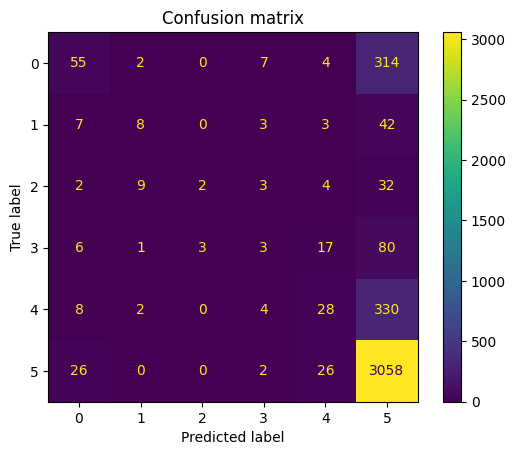

In [32]:
print(classification_report(y_val,y_pred_log))
cm = confusion_matrix(y_val, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

# 2. SVM
Support Vector Machine (SVM) is a powerful supervised learning algorithm that can be used for both binary and multiclass classification problems. For large datasets, SVM with the RBF kernel can efficiently handle high-dimensional feature spaces

In [33]:
svc=SVC(random_state=42)
svc.fit(X_train_new, y_train)
cr=cross_val_score(svc,X_train_new, y_train,cv=cv, scoring='accuracy')
print("Mean Training Accuracy: {:.4f} %".format(cr.mean()*100))

Mean Training Accuracy: 76.2913 %


# 3. RandomForestClassifier
 RandomForest is a specific type of bagging classifier that uses decision trees as base estimators. It creates an ensemble of decision trees trained on random subsets of the training data and features, and then aggregates their predictions through voting (for classification).

In [34]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train_new, y_train)
cr=cross_val_score(rfc,X_train_new, y_train,cv=cv, scoring='accuracy')
print("Mean Training Accuracy: {:.4f} %".format(cr.mean()*100))

Mean Training Accuracy: 76.5322 %


# 4. XGBClassifier
XGBClassifier (XGBoost Classifier) is a popular ensemble learning algorithm used for classification tasks.

In [35]:
xgb=XGBClassifier(random_state=42,objective='multi:softmax')
xgb.fit(X_train_new,y_train)
cr=cross_val_score(xgb,X_train_new, y_train,cv=cv, scoring='accuracy')
print("Mean Training Accuracy: {:.4f} %".format(cr.mean()*100))

Mean Training Accuracy: 77.5693 %


**Hyperparameter tuning performed by RandomizedSearchCV**

In [36]:
xgb = XGBClassifier(objective='multi:softmax',random_state=42)

params = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 6),
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'gamma': np.linspace(0, 0.5, 6)
}

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, cv=5)
random_search.fit(X_train_new, y_train)

best_model_xgb = random_search.best_estimator_
best_score = random_search.best_score_
best_params = random_search.best_params_

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.7765322158198009
Best Parameters: {'subsample': 0.9, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.2677777777777778, 'gamma': 0.4, 'colsample_bytree': 1.0}


In [37]:
y_pred_xgb = best_model_xgb.predict(X_val_new)

accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
recall_xgb=recall_score(y_val,y_pred_xgb,average='weighted')
f1_score_xgb=f1_score(y_val,y_pred_xgb,average='weighted')
precision_xgb=precision_score(y_val,y_pred_xgb,average='weighted')

print('Validation Accuracy',accuracy_xgb*100)

Validation Accuracy 78.09826448301149


              precision    recall  f1-score   support

           0       0.65      0.24      0.35       382
           1       0.28      0.08      0.12        63
           2       0.40      0.08      0.13        52
           3       0.33      0.07      0.12       110
           4       0.39      0.08      0.13       372
           5       0.80      0.98      0.88      3112

    accuracy                           0.78      4091
   macro avg       0.48      0.26      0.29      4091
weighted avg       0.72      0.78      0.72      4091



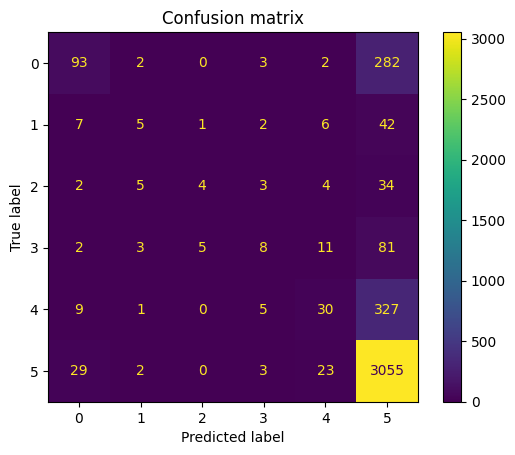

In [38]:
print(classification_report(y_val,y_pred_xgb))
cm = confusion_matrix(y_val, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

# 5. LGBMClassifier

It is observed that LightGBM (Light Gradient Boosting Machine) is particularly well-suited for large dataset multiclass classification problems due to its efficiency, speed, and scalability.

In [39]:
lgb_clf = lgb.LGBMClassifier(random_state=42,verbose=-1,objective= "multiclass")
cr=cross_val_score(lgb_clf,X_train_new,y_train,cv=cv, scoring='accuracy')
print("Mean Training Accuracy : {:.4f} %".format(cr.mean()*100))

Mean Training Accuracy : 77.7475 %


# Hyperparameter tuning performed by RandomizedSearchCV

In [40]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

lgb_clf = lgb.LGBMClassifier(random_state=42, verbose=-1,objective= "multiclass")

random_search = RandomizedSearchCV(estimator=lgb_clf, param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy', cv=5, random_state=42)

random_search.fit(X_train_new, y_train)

best_model_lgb = random_search.best_estimator_
best_score = random_search.best_score_
best_params = random_search.best_params_

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.7789418543740178
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 16, 'n_estimators': 882, 'subsample': 0.8}


In [41]:
y_pred_lgb=best_model_lgb.predict(X_val_new)

accuracy_lgb=accuracy_score(y_val,y_pred_lgb)
recall_lgb=recall_score(y_val,y_pred_lgb,average='weighted')
f1_score_lgb=f1_score(y_val,y_pred_lgb,average='weighted')
precision_lgb=precision_score(y_val,y_pred_lgb,average='weighted')

print('Validation accuracy:',accuracy_lgb*100)

Validation accuracy: 77.90271327303839


              precision    recall  f1-score   support

           0       0.64      0.24      0.35       382
           1       0.39      0.11      0.17        63
           2       0.21      0.06      0.09        52
           3       0.39      0.06      0.11       110
           4       0.36      0.07      0.12       372
           5       0.80      0.98      0.88      3112

    accuracy                           0.78      4091
   macro avg       0.47      0.25      0.29      4091
weighted avg       0.72      0.78      0.72      4091



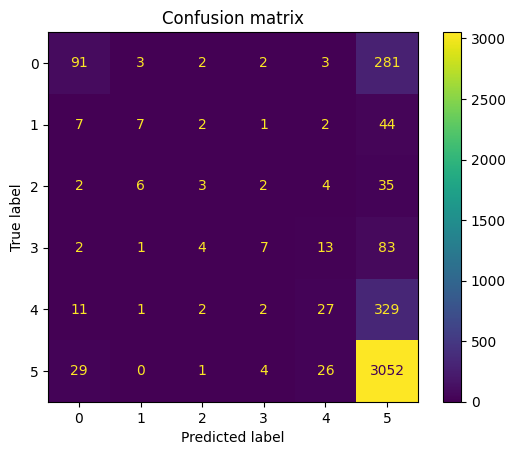

In [42]:
print(classification_report(y_val,y_pred_lgb))
cm = confusion_matrix(y_val, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

# The best 3 models performance 

In [43]:
print('MODEL 1: Logistic Regression')
print(f'Accuracy:  {accuracy_log}')
print(f'Precision: {precision_log}')
print(f'Recall:    {recall_log}')
print(f'F1_score:  {f1_score_log}\n')

print('MODEL 2: XGBClassifier')
print(f'Accuracy:  {accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall:    {recall_xgb}')
print(f'F1_score:  {f1_score_xgb}\n')

print('MODEL 3: LGBMClassifier')
print(f'Accuracy:  {accuracy_lgb}')
print(f'Precision: {precision_lgb}')
print(f'Recall:    {recall_lgb}')
print(f'F1_score:  {f1_score_lgb}')


MODEL 1: Logistic Regression
Accuracy:  0.7709606453189929
Precision: 0.6980502728621536
Recall:    0.7709606453189929
F1_score:  0.7050452121537443

MODEL 2: XGBClassifier
Accuracy:  0.7809826448301149
Precision: 0.7235702436708412
Recall:    0.7809826448301149
F1_score:  0.7224689530361692

MODEL 3: LGBMClassifier
Accuracy:  0.7790271327303838
Precision: 0.7188667899281599
Recall:    0.7790271327303838
F1_score:  0.7196211131245273


# **ROC curve using micro-averaged OvR**

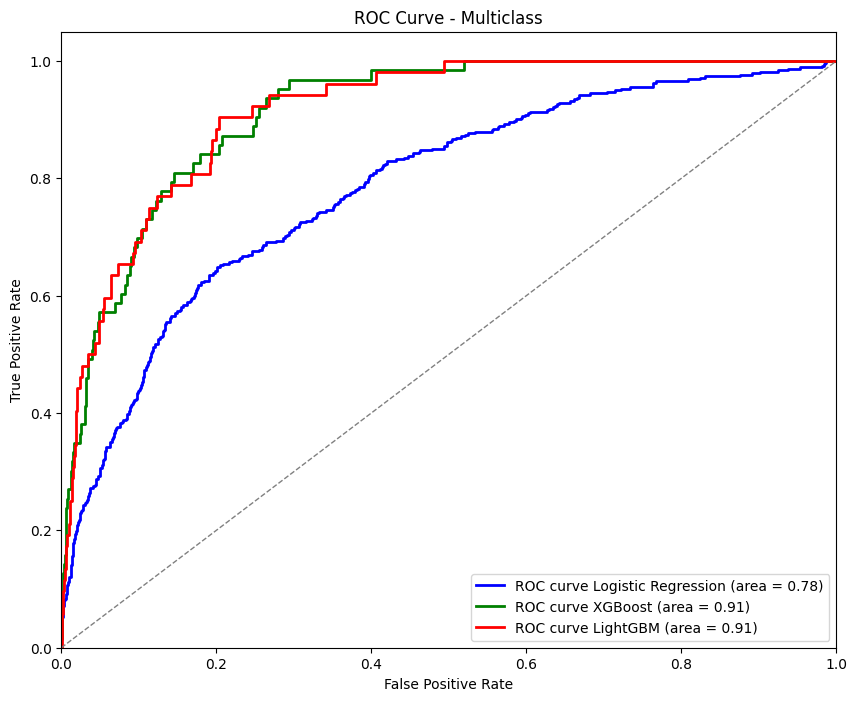

In [44]:

logreg_probs = best_model_log.predict_proba(X_val_new)
xgb_probs = best_model_xgb.predict_proba(X_val_new)
lgb_probs= best_model_lgb.predict_proba(X_val_new)
all_probs = np.hstack([logreg_probs, xgb_probs, lgb_probs])

n_classes = len(np.unique(y_train))
y_val_bin = label_binarize(y_val, classes=np.unique(y_train))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']  
model_names = ['Logistic Regression', 'XGBoost', 'LightGBM']

for i, color, model_name in zip(range(n_classes), colors, model_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve {} (area = {:0.2f})'.format(model_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc='lower right')
plt.show()

For the test data, the data is predicted by LGBMClassifier. The training accuracy for XGBoostClassifier and LGBMClassifier were close to each other, hence the model was chosen by also considering the validation accuracy and classification report.

In [45]:
y_test_=best_model_lgb.predict(test_new)
submission=pd.DataFrame({"ID": range(1,4547),
                        "Rating": y_test_})
submission.to_csv('submission.csv', index=False)